# MLGO: a Machine Learning Guided Compiler Optimizations Framework

We propose MLGO, a framework for integrating ML techniques systematically in an industrial compiler using LLVM

As a case study, we present the details and results of replacing
the heuristics-based inlining-for-size optimization in LLVM
with machine learned models.

Policy Gradient and Evolution Strategies

### Introduction

In the compiler case, heuristics are widely used in optimization passes, even those leveraging profile feedback, such as inlining and register allocation.


Reinforcement Learning (RL) is
a family of machine learning techniques that may be applied
to find increasingly optimal solutions through an automated
iterative exploration and training process.

The chosen problem is inlining-for-size in LLVM, and in
particular, the inlining decision heuristics.

We chose **size rather than speed** for the pilot because
size is relatively easy to measure and non-noisy.

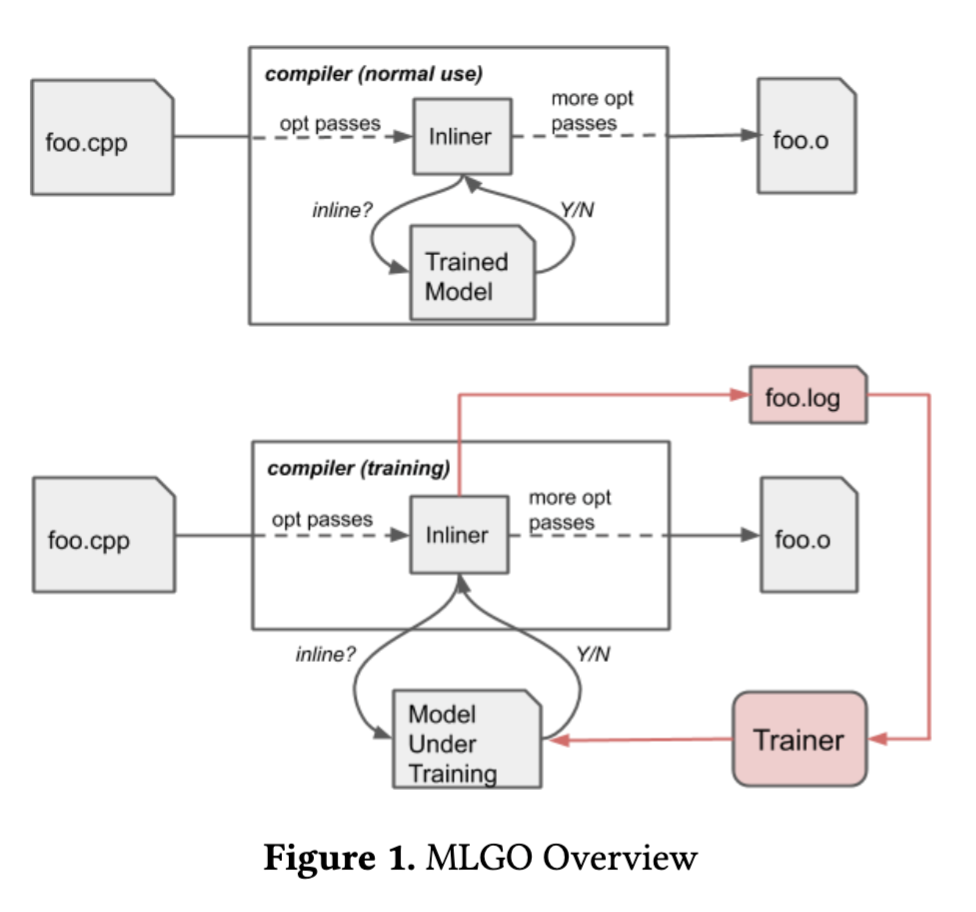

From a very high level, our MLGO framework separates
the use of the compiler from the training of policies as shown
in Figure 1.

Day-to-day production use is unchanged; as an
implementation detail, a trained model embedded in the
compiler is used to make decisions (in this case, inlining)
that were previously handled by a manual heuristic.

Training happens separately using a large, representative corpus
of intermediate representation (IR) modules.

The training
process is iterative, each step using an updated policy, so the policy is not embedded in the compiler.

During training, the inliner produces a log that records the inlining process
(features, decisions, etc). The logs are collected and fed to
the training algorithm to produce a new model.

Contents

1. Intro
2. Provides an overview of the relevant ML techniques and the LLVM inliner.
3. Gives an overview of MLGO: our framing of the problem of applying ML to compiler optimizations, and our methodology.
4. describes the policy training in MLGO for the inlining problem.
5. Details the implementation, in LLVM, of our pilot project.
6. The results
7. The related work
8. Discussion of plans
9. Conclusion

A note: throughout this paper, we use interchangeably the
terms policy and model.

# Background
### Machine Learning Techniques for Replacing Compiler Optimization Heuristics

There are two characteristics that make reinforcement learning (RL) a suitable tool for replacing compiler optimization
heuristics:
- There are no examples showing optimal strategies for these heuristics — in the inlining problem, we don’t know whether inlining or not for a certain call site is the optimal choice;
- We can efficiently explore different strategies, and improve strategies from those experiences. The absence of examples ("labels") means we cannot use supervised learning.

# High-level Overview of the Current LLVM Inlining Pass

Today’s LLVM inliner is a pass operating on a strongly-
connected component (SCC) of the static call graph in a
module, at a time in bottom up order.

The inlined callee’s call sites are added to a work list and iteratively considered
for inlining in a top down fashion.

A pipeline of optimizations (Inst combine, scalar replacement of aggregates (SROA),
loop optimizations, etc) is then applied on each function in
the SCC3, after the SCC was processed.

The effects of these optimizations impact inlining decisions of call sites in the
SCC calling into the last one.

**LLVM inlining** consists of many heuristics:
- The choice of call site traversal
- The set of "cleanup" function passes run on functions after they are modified because call sites were inlined
- The timing of these cleanups
- The decision to inline or not a specific call site.

The decision to inline or not a call site is itself built on
top of a rich set of heuristics. 

The compiler first computes
the static "cost" of the callee post inlining by traversing the
callee body simulating post-inline cleanup passes.

The computed cost is then compared with a threshold.
The threshold value is based on things like call site hotness,
inline keyword, etc. 

*The SIMD library provides portable types for explicitly stating data-parallelism. Single instruction multiple data.*

# MLGO

MLGO is a set of guidelines and requirements derived from
our understanding of the problem of leveraging ML techniques for replacing manual optimization heuristics. We start
with our understanding of the participating personas and
their scenarios, which then motivates MLGO guidelines and
design decisions.

### Persona: Compiler User

- correctness and performance of the generated code
- compilation determinism (i.e. identical output for identical input) - to leverage incremental builds;
- avoiding the added cost and complexity of new infrastructure requirements on build and release pipelines, such as new compiler run-time dependencies or new steps (like training);
- and timeliness of the build, as it impacts hardware resource planning and developer productivity

Our goal is to introduce no changes to this user.

- We replace heuristics, not semantics-preserving code. For example, we change the decision making process for carrying out function inlining, not how the inlining action is implemented.
- Policy training happens offline. Trained policies are embedded in the compiler as statically linked native code. Build determinism using the ML-enabled compiler is ensured because the policies are fixed - no training happens when the compiler runs, only inference.
- We require ML techniques that yield policies that generalize well over different code bases and code changes, and do not need frequent retraining.

### Persona: Compiler Engineer

1. Policy Creation. The engineer wants to incorporate
ML techniques in a compiler optimization pass.
2. Policy Improvement. Here, they investigate a specific regression encountered in production, or want to
improve a ML-enabled pass.
3. "The Ship Blocker". The engineer must quickly resolve a ship-blocking regression introduced by a hot patch, and caused by a misbehaving RL-enabled policy

We refer to this use
of policies as development mode.

Here, models are loaded
via a command line option, the compiler may have extra
runtime dependencies, and model evaluation may involve
changes to the runtime behavior of the compiler — because, for example, the model evaluators may be multi-threaded and/or JIT-ing

### Policy Improvement is currently (i.e. for manual heuristics) an iterative engineering process

In the MLGO methodology, we envision a gradual
process:

1. Start by incorporating regression use-case(s) into training corpus and retrain the policy
2. If that fails, hypothesize missing features. The needed skill set is close to what compiler engineers currently employ for manual heuristic development, and, just like for manual heuristics, evolving the feature set is likely an iterative process. Typically, adding features and retraining shouldn’t result in regressions for the previous training corpus, which is a benefit of our approach over the manual heuristic case.
3. If the above also fails, involve an ML expert to investigate alternative training algorithms

**Ship blockers** are those cases where the compiler engineer
doesn’t have the luxury to do deep investigations into compiler behavior, since they are on a tight time budget.

Assuming the pathological case is identified (i.e. which compilation
unit causes the compiler to misbehave), in the case of manual heuristics, the levers of control are:
- Trial-and-error with different compilation flag values (change policy thresholds, for instance)
- Modify user code (use inlining directives, for instance)
- Or disable the specific optimization for a specific module

Other than policy thresholds, the control levers available to the engineer are the same.

*Overfit policies to special cases.*

An engineer could attempt to specialize
a policy to overfit for the pathological case, and compile
that case with the specialized policy (while compiling the
rest of the project with the non-overfitted policy)

# MLGO Policy Training

### RL Problem Formulation

RL aims to find an optimal policy for a Markov Decision Process (MDP)

MDP is a mathematical framework that models
sequential decision making — in inlining-for-size problem, we make sequential decisions whether to inline or not.

An
MDP can be represented by the tuple < S, A, P, R > with state space S, action space A, state transition distribution P (𝑠′|𝑠, 𝑎), and reward function R (𝑠, 𝑎). In the MDP formalism, at time 𝑡, the agent observes the state 𝑠𝑡 ∈ S of the nvironment, then decides to take an action 𝑎𝑡 ∈ A. It also
receives the reward 𝑟𝑡 = R (𝑠𝑡 , 𝑎𝑡 ). The environment state then transitions to 𝑠𝑡+1 ∈ S by sampling from the probability distribution P (𝑠𝑡+1 |𝑠𝑡 , 𝑎𝑡 ).

This process repeats until
the agent reaches a termination state at time 𝑇 . The agent’s decisions are a function (we call it policy) 𝜋 = 𝑃𝑟 (𝑎|𝑠) that maps observed state 𝑠 to a distribution over actions. In our case, 𝜋 is a neural network and we call it policy network. RL algorithms aim to find the optimal policy 𝜋∗ to maximize the total reward.

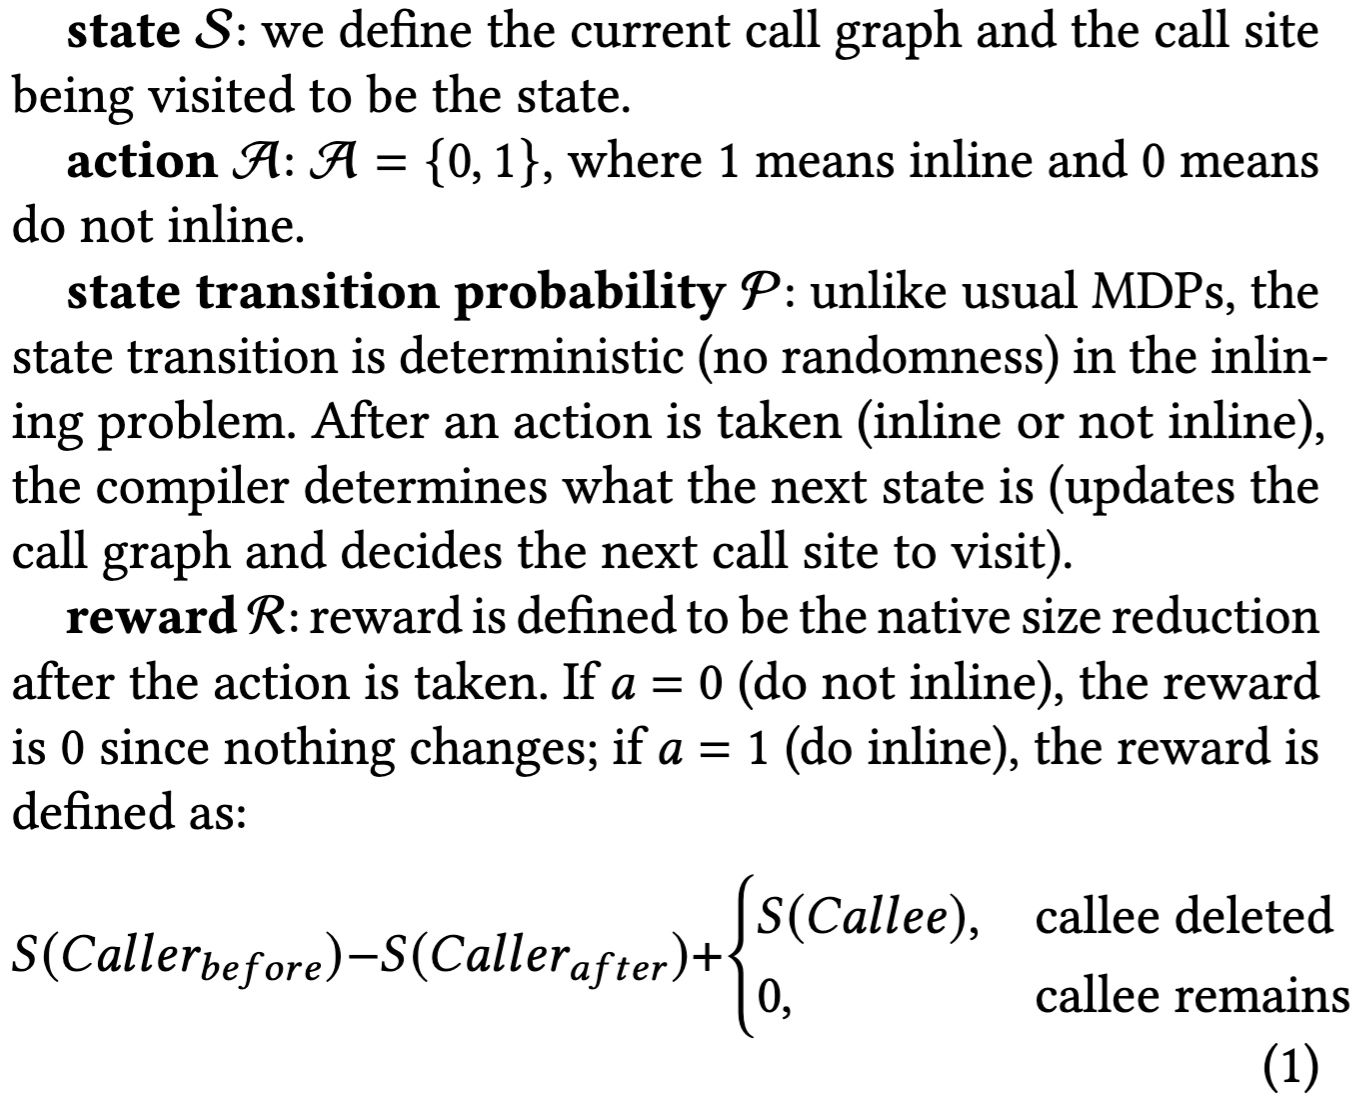

Where 𝑆 (𝑓) is the native size of function 𝑓. Note that we do not actually know what the native size would be for a certain function while performing inlining, since inlining operates at the IR level. 

The definition for reward here is
not practical for training. We will discuss how we tackle this challenge next.


### Policy Gradient Algorithm

Page 5

We choose to use the total
reward 𝑅 since:
- It is directly available in the inlining-
for-size problem, while partial returns would have to be approximated
- It is difficult to build the value network 𝑉(𝑠𝑡) with the reduced state.

### Challenges and Implementation Details
We run into two challenges when applying PPO to the inlining-for-size problem:

- complex state space; 
- impractical reward definition.

**Complex state space:** Our MDP formulation defines the state as the current call graph and the call site being visited. Unfortunately, encoding and processing a call graph at each decision point may not be computationally practical for a general-purpose compiler to afford.

**Impractical reward definition:** It is difficult to know a function’s native size 𝑆 (𝑓 ) during the inlining pass because native code lowering happens in a later pass, and because its structure may change due to more of its call sites being inlined.

To tackle the first challenge, we approximate the true
state by distilling the state space to 11 numerical features as listed in Table 1.

These features describe the local call site and
provide some global information about the call graph. Section 5.1 details the features we use. We considered, but rejected for now, the use of (IR) code embedding techniques[3]; this allows us to minimize additional computational/memory
costs.

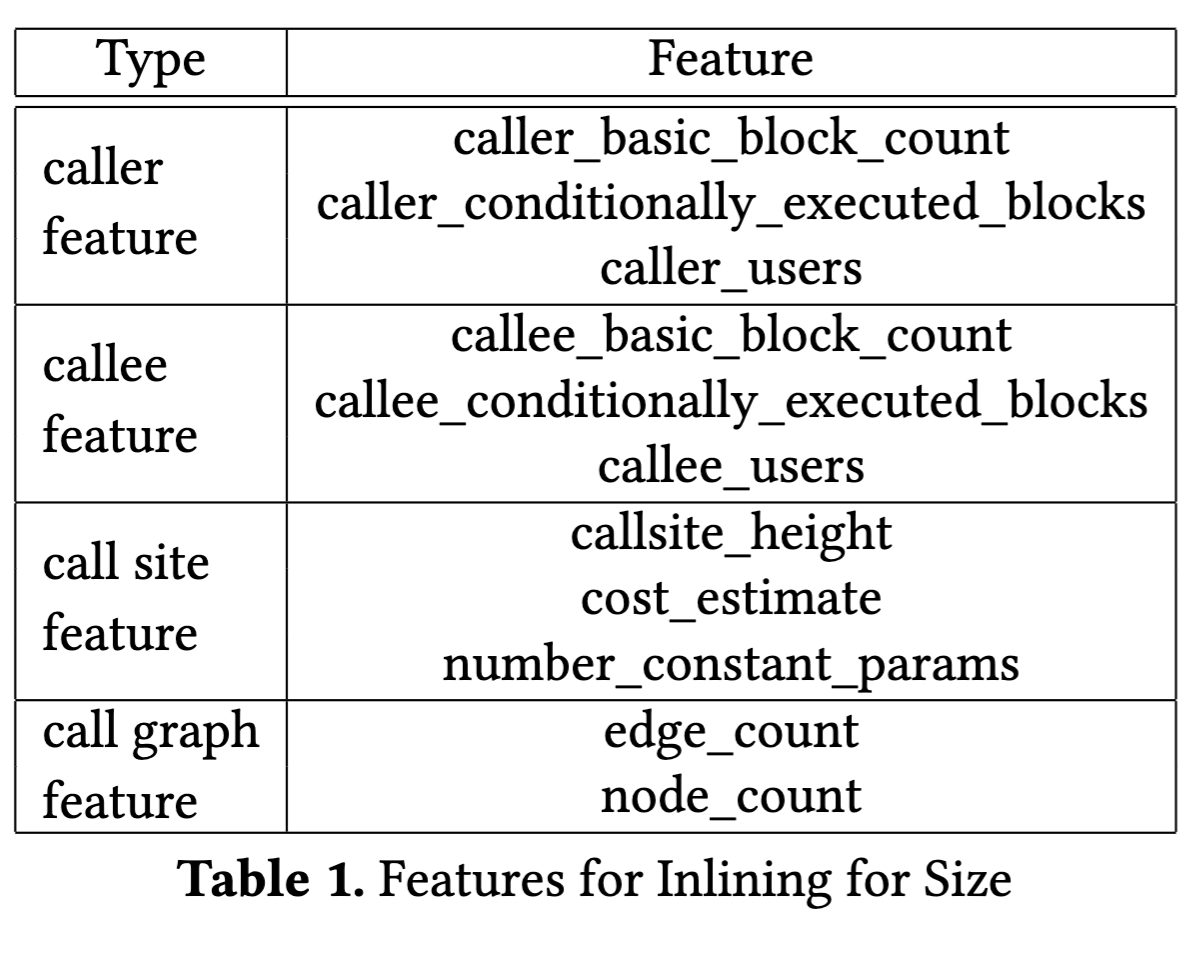

One drawback of the simplified state is that it greatly reduces information available to the policy — it only contains a part of the local call site information, and limited global call graph information.


*to use the total reward 𝑅 instead of the partial return as shown in Equation := it is relatively easy to evaluate: evaluate native size with / without inlining, and substract*

### Warmstart with Behavioral Cloning Policy

Instead of having the RL algorithm learn from the scratch (initialize 𝜃 randomly), we facilitate training by initializing 𝜃 from some "warmstart" policy.

Therefore, we train the warmstart policy to imitate the heuristic inlining decisions in LLVM using behavioral cloning algorithm[ 4].

# Evolution Strategies

ES focuses on black-box optimization problems of the form max𝜃 𝐹 (𝜃 ), where 𝐹 can be any black-box function that can be evaluated.

Instead of directly optimizing 𝐹 (𝜃), ES focuses on optimizing 𝐽 (𝜃), which is a smoothed version of 𝐹 (𝜃):

### PG vs ES
- Sample Efficiency (Es requires 20x more data)
- Complexity (ES is easier)

# Training Infrastructure

At each iteration, the trainer sends the policy 𝜋𝜃 to data collector, the data collector samples several IR files from the IR corpus, does compilation to collect training data, and sends the training data back to the trainer for training.

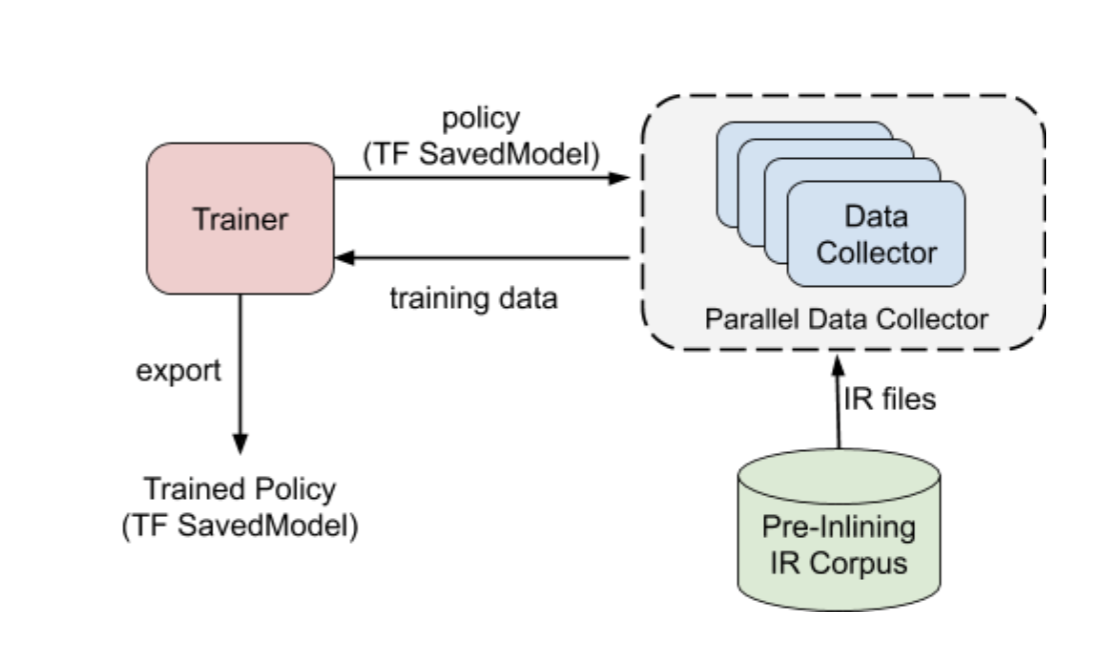

The bottleneck of training for the inlining problem is data collection.

### How the data collector module works
It takes a pre-inlining IR file and a policy (optional) as inputs, conducts inlining on the IR file based on the policy, has the post-inlining IR file optimized by other opt passes after inlining, converts the optimized IR file into native code, and gets the native size of this module.

The native size, together with the log file generated during inlining by MLGO that contains the trajectory (𝑠1, 𝑎1, 𝑠2, 𝑎2, ..., 𝑠𝑇 , 𝑎𝑇 ), composes the output of the data collector module — training data

If the policy is not given, the inliner will conduct the current heuristic inlining and log the trace. It has two use-cases as discussed in Section 4.1: 
- collect data to train the warmstart policy with behavioral cloning algorithm; 
- use the heuristic inlining as the baseline.

# LLVM Implementation

We implemented the pilot project in LLVM8, together with reusable support for release and development modes, as well as continuous integration build bots

### RL Driven Inlining (for Size) in LLVM

**InlineAdvisor** for the inline decision-making
policy

ModuleInliner-WrapperPass (llvm/Transforms/IPO/Inliner.h)

The specific
implementation of the advisor is chosen through a LLVM
flag (-enable-ml-inliner). By default, the implementation is
the manual heuristic. Passing ’release’ or ’development’ to
the flag selects the respective mode, if the compiler was built
with support for that mode.

Feature extraction is modeled as a separate analysis, FunctionPropertiesAnalysis, and reused by the release and development implementations. The full feature set is captured in
llvm/Analysis/InlineModelFeatureMaps.h.

We capture somecall site-local information, as well as global information, such
- as module-wide number of functions and static calls, caller/callee user counts;
- position in the original call graph, as the distance of the call site to the farthest SCC; 
- and an estimate of removed instructions given the call site context


We use TensorFlow [ 1 ] as the model training and inference framework.
In both modes, the interface between LLVM
and the model is defined solely in terms of input and output
tensor specifications (tensor name, type, and shape). The
internal structure of the model is an implementation detail.
This means that during training, the compiler engineer is
free to explore hyper-parameters or add/modify hidden layers.

Also, ingesting a new model with a different internal
structure, in release mode, is just a matter of recompiling
LLVM.

lib/Analysis/{MLInlineAdvisor | ReleaseMode-ModelRunner | DevelopmentModeInlineAdvisor}.cpp

At a high level, both release and development modes:

- Handle user inlining directives and correctness aspects (these are done without model evaluation)

- Extract the features associated with a call site and form fixed-sized tensors (primitive data type vectors), and efficiently maintain the module-wide features

- Pass the tensors to the model evaluator, and request it perform an evaluation ake the result of the evaluation as advice (i.e. inline/-don’t) and make that available to the inliner pass

- It is possible that a policy misbehaves in unforeseen circumstances (which, as a note, should then be in- corporated into the training loop). The resulting IR, while correct, could become increasingly expensive to process by subsequent passes. To avoid this, we set a hard threshold to the amount by which the number of instructions may grow in a compilation unit

### Release Mode Implementation in LLVM

The model is encoded in the TensorFlow serialization format,
SavedModel [31 ], which is compiled into native code by the
saved_model_cli tool [ 32].

Applying the rule to a model
generates a header file and an object file. From here, the
model may be consumed as a C function; for simplicity, the
SavedModel compiler provides a thin C++ wrapper, exposing
plain C/C++ APIs (primitive types), which is compiled as
part of the LLVM build process. The SavedModel is checked
in as source

### Development Mode Implementation in LLVM

As discussed, in development mode, we want to support
loading models from the command line ...

In addition to facilitating a different model ingestion mechanism, the development mode is responsible for producing
traces necessary for training ("training logs")

These logs capture the succession of feature values observed when the
policy is asked to make a decision, and the decision made
afterwards ("trajectories"). Training logs may be produced
for both the heuristic policy (for bootstrapping training -
"warmstart") as well as for the ML policy currently under
training. 

We encode the training logs
as textual SequenceExamples[30] proto-buffers, the typical
abstraction Tensorflow training algorithms would expect.
We produce a textual output to avoid an additional dependency to LLVM, and to simplify diagnostics and testing of
the feature.

# Evaluation

### Compilation Overhead

Model evaluation in release mode has fixed cost, both in
terms of compiler run-time memory utilization, as well as
CPU utilization. 

For the current model, we observed 0.65% increase in memory utilization at run-time. When inlining a large IR module ( 33MB), we measured a 10% increase in inlining time, mostly attributable to feature extraction; since inlining tends
to represent 10-15% of total compile time, the net contribution of the release mode is only 1%. Finally, clang binary size increase due to the inclusion of the compiled model was 115KB, representing 0.08% size increase.

### Inlining for Size Results

Results.

### Generalizability across Software

### Generalizability across Time

### Related Work



# Future Directions
### Applying MLGO to Speed Optimizations

The immediately-observable difference between our pilot
project and **speed problems** is that the reward is measured differently: speed is measured through benchmark runs, which
are more time consuming and more noisy than size measurements.

Using benchmark runs results as reward for speed
optimization will have difficulties scaling, so our current preference is to avoid benchmark runs altogether, and focus
instead on using problem-specific reward approximations.

For **inlining for speed**, we plan to use
a linear combination of a per-critical call graph estimate
of working set (i.e. cache lines needed for execution) and
dynamic instruction count. Both approaches require profiling
information for carrying out the analysis, which we assume
as a pre-requisite for workloads that are concerned with
speed.

### ML Techniques

There are multiple directions to pursue in terms of the ML
techniques:
Richer State Representations: instead of using the 11
numerical features to represent the state, we can have richer
state representations. For example, we can use code embedding techniques [3] to embed the caller/callee to get
more detailed information about the call site; or we can use
graph neural network techniques [14 ] on the neighboring
sub-graph of the call site to get more information about the
call graph.

# Conclusion

We investigated the problem of leveraging ML techniques for
compiler optimization in a real-world setting. We proposed a
particular understanding of the problem space, and derived
the MLGO framework. We applied it to inlining-for-size and
described the resulting implementation, available in LLVM as
a build-time opt-in, as well as the training methodology, two
training algorithms and their trade-offs, and results. We are
currently applying the same principles to addressing inlining
for speed and register allocation policies, and hope that,
through our experience, as well as that of the community,
we can further refine MLGO and eventually mature it to
a solution that compiler engineers can broadly apply and
leverage machine learning for compiler optimizations in real-
world settings.